In [30]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from xgboost import XGBClassifier

In [25]:
data = pd.read_csv('eventmatrixlabel.csv')

In [26]:
data.shape

(575061, 50)

In [27]:
# Changing Anomaly = 1, Normal = 0
data['Label'] = pd.factorize(data['Label'])[0]

In [28]:
# Counting % of anomalies
np.round(np.mean(data['Label']),5)*100

2.928

Only 3% of our rows are Anomaly, we thus have a very unbalanced dataset. In order to take this into account, we must use appropriate metrics to evaluate the performance of our models. 

In [31]:
# Keep in mind that accuracy will be high even if does not identify anomaly properly (because of unbalanced data)
# true: Anomaly, false: Normal

# precision : Of those predicted true, proportion that are  true
# Recall/Sensitivity : Of actual trues, proportion predicted true
# Specificity : Of actual falses, proportion predicted false --> not important to us

metrics = {'balanced_accuracy': metrics.make_scorer(metrics.balanced_accuracy_score), 
           'precision': metrics.make_scorer(metrics.precision_score),
          'recall' : metrics.make_scorer(metrics.recall_score),
          'f1' : metrics.make_scorer(metrics.f1_score),
          'log-loss' : metrics.make_scorer(metrics.log_loss)}

In [32]:
# Splitting the dependent and independent variables
y = data[['Label']]
x = data.drop(['Label', 'BlockId'], axis=1)

In [33]:
len(x)

575061

In [37]:
# Splitting data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 2021)

In [38]:
print(f"% of anomalies in training set: {np.round(np.mean(y_train['Label'])*100,3)}")
print(f"% of anomalies in testing set: {np.round(np.mean(y_test['Label'])*100,3)}")

% of anomalies in training set: 2.934
% of anomalies in testing set: 2.906


In [39]:
y_train = np.ravel(y_train)

# Random Forests

### Default Random Forest

In [10]:
# Lets fit a rf with default parameters
rf_default = RandomForestClassifier(random_state = 2021)

In [50]:
# Define evaluation procedure
cv_rf_default = cross_validate(rf_default, X = x_train, y = y_train,scoring = metrics, n_jobs = -1, cv = 5, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


In [51]:
pd.DataFrame.from_dict(cv_rf_default).set_axis(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'], axis=0)

,fit_time,score_time,test_balanced_accuracy,test_precision,test_recall,test_f1,test_log-loss
Fold_1,16.934275,0.712536,0.998658,0.997037,0.997406,0.997222,0.005631
Fold_2,17.301031,0.661962,0.999371,0.995201,0.998888,0.997041,0.006006
Fold_3,16.779449,0.739297,0.999764,0.996677,0.999630,0.998151,0.003754
Fold_4,16.801463,0.740284,0.999225,0.997779,0.998518,0.998148,0.003754
Fold_5,17.118866,0.686632,0.999809,0.999629,0.999629,0.999629,0.000751


In [52]:
# Average of all folds
metrics_rf_default = pd.DataFrame.from_dict(cv_rf_default).set_axis(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'], axis=0).mean(axis = 0)
metrics_rf_default = pd.DataFrame(metrics_rf_default).set_axis(['Avg Fit Time', 'Avg Score Time', '5-Fold Balanced Accuracy', '5-Fold Precision', '5-Fold Recall', '5-Fold F1', '5-Fold Log Loss'], axis = 0).T.set_axis(['Random Forest'])
metrics_rf_default

,Avg Fit Time,Avg Score Time,5-Fold Balanced Accuracy,5-Fold Precision,5-Fold Recall,5-Fold F1,5-Fold Log Loss
Random Forest,16.987017,0.708142,0.999366,0.997265,0.998814,0.998038,0.003979


### Random Forest with Bootstrap Class Weighting

In [56]:
# Lets place a heavier penalty on misclassifying the minority class - Anomaly, using Random Forest With Bootstrap Class Weighting
rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced_subsample', random_state = 2021)

In [57]:
# Define evaluation procedure
cv_rf = cross_validate(rf, X = x_train, y = y_train,scoring = metrics, n_jobs = -1, cv = 5, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


In [58]:
pd.DataFrame.from_dict(cv_rf).set_axis(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'], axis=0)

,fit_time,score_time,test_balanced_accuracy,test_precision,test_recall,test_f1,test_log-loss
Fold_1,22.635645,0.730291,0.998658,0.997037,0.997406,0.997222,0.005631
Fold_2,22.745514,0.723727,0.999371,0.995201,0.998888,0.997041,0.006006
Fold_3,22.804771,0.725111,0.999955,0.997046,1.000000,0.998521,0.003003
Fold_4,22.771705,0.719185,0.999405,0.997410,0.998888,0.998149,0.003754
Fold_5,22.617647,0.744289,0.999809,0.999629,0.999629,0.999629,0.000751


In [59]:
# Average of all folds
metrics_rf_bootstrap = pd.DataFrame.from_dict(cv_rf).set_axis(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'], axis=0).mean(axis = 0)
metrics_rf_bootstrap = pd.DataFrame(metrics_rf_bootstrap).set_axis(['Avg Fit Time', 'Avg Score Time', '5-Fold Balanced Accuracy', '5-Fold Precision', '5-Fold Recall', '5-Fold F1', '5-Fold Log Loss'], axis = 0).T.set_axis(['Random Forest Bootstrap Class Weighting'])
metrics_rf_bootstrap

,Avg Fit Time,Avg Score Time,5-Fold Balanced Accuracy,5-Fold Precision,5-Fold Recall,5-Fold F1,5-Fold Log Loss
Random Forest Bootstrap Class Weighting,22.715056,0.72852,0.99944,0.997265,0.998963,0.998112,0.003829


### Random Forest Grid Search

In [40]:
# Create the random grid
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)], # Number of trees in random forest
               'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider at every split
               'min_samples_split': [2, 5, 10, 20], # Minimum number of samples required to split a node
               'class_weight': ['balanced_subsample', 'balanced', None]} # Weights associated with classes. 

rf_grid = GridSearchCV(estimator = rf_default, 
                               param_grid = param_grid,  
                               cv = 3, 
                               scoring = 'f1',
                               verbose = 2,  
                               n_jobs = -1)

In [41]:
# Fit the random search model
rf_grid.fit(x_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2021),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced_subsample', 'balanced',
                                          None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1', verbose=2)

In [43]:
rf_grid.best_params_

{'class_weight': None,
 'max_features': 'log2',
 'min_samples_split': 20,
 'n_estimators': 100}

We obtain a `min_samples_split` of 20, which is the highest number of split in our grid. Maybe this means that a higher number of min_samples_split would perform better. Lets adjust our grid accordingly.

In [44]:
# Adjusting grid search
param_grid_adj = {'n_estimators': [100, 200], # Number of trees in random forest
               'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider at every split
               'min_samples_split': [5, 10, 20, 30, 50], # Minimum number of samples required to split a node
               'class_weight': ['balanced_subsample', 'balanced', None]} # Weights associated with classes. 

rf_grid_adj = GridSearchCV(estimator = rf_default, 
                               param_grid = param_grid,  
                               cv = 3, 
                               scoring = 'f1',
                               verbose = 2,  
                               n_jobs = -1)

In [46]:
# Fit the random search model
rf_grid_adj.fit(x_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2021),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced_subsample', 'balanced',
                                          None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1', verbose=2)

In [60]:
rf_grid_adj.best_params_

{'class_weight': None,
 'max_features': 'log2',
 'min_samples_split': 20,
 'n_estimators': 100}

With the adjusted parameter grid, we obtain the same parameters. Lets fit our model with these parameters.

In [61]:
rf_adj = RandomForestClassifier(n_estimators = 100, class_weight = None, max_features = 'log2', min_samples_split = 20, random_state = 2021)
cv_rf_adj = cross_validate(rf_adj, X = x_train, y = y_train, scoring = metrics, n_jobs = -1, cv = 5, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished


In [62]:
rf_adj.fit(x_train, y_train)
importances = rf_adj.feature_importances_

In [31]:
pd.DataFrame.from_dict(cv_rf_adj).set_axis(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'], axis=0)

,fit_time,score_time,test_balanced_accuracy,test_precision,test_recall,test_f1,test_log-loss
Fold_1,20.456935,0.816421,0.998473,0.997036,0.997036,0.997036,0.006006
Fold_2,20.193654,0.890186,0.999557,0.995203,0.999259,0.997227,0.005631
Fold_3,20.815618,0.748269,0.999764,0.996677,0.999630,0.998151,0.003754
Fold_4,20.750161,0.759725,0.999781,0.997781,0.999629,0.998704,0.002628
Fold_5,20.345312,0.822366,0.999809,0.999629,0.999629,0.999629,0.000751


In [64]:
# Average of all folds
metrics_rf_tuned = pd.DataFrame.from_dict(cv_rf_adj).set_axis(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'], axis=0).mean(axis = 0)
metrics_rf_tuned = pd.DataFrame(metrics_rf_tuned).set_axis(['Avg Fit Time', 'Avg Score Time', '5-Fold Balanced Accuracy', '5-Fold Precision', '5-Fold Recall', '5-Fold F1', '5-Fold Log Loss'], axis = 0).T.set_axis(['Random Forest Tuned'])
metrics_rf_tuned

,Avg Fit Time,Avg Score Time,5-Fold Balanced Accuracy,5-Fold Precision,5-Fold Recall,5-Fold F1,5-Fold Log Loss
Random Forest Tuned,16.501245,0.75664,0.999477,0.997265,0.999037,0.99815,0.003754


# Gradient Boosting

### Default XGBoost

In [74]:
xgboost_default = XGBClassifier()
cv_xgboost_default = cross_validate(xgboost_default, X = x_train, y = y_train,scoring = metrics, n_jobs = -1, cv = 5, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.2s finished


In [75]:
pd.DataFrame.from_dict(cv_xgboost_default).set_axis(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'], axis=0)

,fit_time,score_time,test_balanced_accuracy,test_precision,test_recall,test_f1,test_log-loss
Fold_1,53.556060,0.387863,0.997917,0.997033,0.995924,0.996478,0.007132
Fold_2,53.730955,0.369215,0.999192,0.995567,0.998518,0.997040,0.006006
Fold_3,53.754620,0.362644,0.999764,0.996677,0.999630,0.998151,0.003754
Fold_4,53.284731,0.425224,0.999225,0.997779,0.998518,0.998148,0.003754
Fold_5,53.614178,0.367992,0.998877,0.999258,0.997777,0.998517,0.003003


In [76]:
# Average of all folds
metrics_xgb = pd.DataFrame.from_dict(cv_xgboost_default).set_axis(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'], axis=0).mean(axis = 0)
metrics_xgb = pd.DataFrame(metrics_xgb).set_axis(['Avg Fit Time', 'Avg Score Time', '5-Fold Balanced Accuracy', '5-Fold Precision', '5-Fold Recall', '5-Fold F1', '5-Fold Log Loss'], axis = 0).T.set_axis(['XGBoost'])
metrics_xgb

,Avg Fit Time,Avg Score Time,5-Fold Balanced Accuracy,5-Fold Precision,5-Fold Recall,5-Fold F1,5-Fold Log Loss
XGBoost,53.588109,0.382588,0.998995,0.997263,0.998073,0.997667,0.00473


### Tuning XGBoost with Bayesian Optimization

After trying to tune the hyperparameters on all the training set, I quickly, or not so quickly, realised that it was extremely long. To remedy this, I decided to tune the hyperparameters on only 20% of the training data. This could be seen as the validation set. 

In [22]:
# Splitting data into smaller training and testing set
import math
x_train_smaller = x_train.iloc[:math.floor(len(x_train)*0.2), :]
y_train_smaller = y_train[:math.floor(len(x_train)*0.2)]

Lets make sure that there is still approximately 3% of anomalies in these datasets so that they are representative of our overall datasets and that our parameters are tuned accordingly.

In [79]:
print(f"% of anomalies in smaller training set: {np.round(np.mean(y_train_smaller)*100,3)}")

% of anomalies in smaller training set: 2.974


In [23]:
len(x_train_smaller)

92009

In [81]:
# will use f1 score to tune parameters 
from bayes_opt import BayesianOptimization
import time

def xgboost(max_depth, gamma, learning_rate, n_estimators, subsample):
    params = {}
    params['max_depth'] = round(max_depth) # must be integer
    params['gamma'] = gamma
    params['learning_rate'] = learning_rate
    params['n_estimators'] = round(n_estimators) # must be integer
    params['subsample'] = subsample
    
    model = XGBClassifier(random_state = 2021, **params, verbosity = 0)
    scores = cross_val_score(model, x_train_smaller, y_train_smaller, scoring = 'f1' , cv = 5)
    avg_score = scores.mean()
    
    return avg_score
    
# Run Bayesian Optimization

start = time.time()

params_xgb = {
    'max_depth' : (1, 8),
    'gamma' : (0, 5),
    'learning_rate' : (0.01, 1),
    'n_estimators' : (50, 350),
    'subsample' : (0.8, 1)
}

xgb_tuned = BayesianOptimization(xgboost, params_xgb, random_state = 2021)
xgb_tuned.maximize(init_points = 20, n_iter = 4)
print(f'It took {(time.time() - start)/60} minutes to run')  

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.9938   |  3.03     |  0.736    |  1.973    |  143.8    |  0.9994   |
|  2        |  0.9947   |  0.6408   |  0.1872   |  6.27     |  248.6    |  0.9569   |
|  3        |  0.9943   |  0.4845   |  0.06799  |  7.737    |  235.0    |  0.8173   |
|  4        |  0.9938   |  2.806    |  0.6204   |  7.747    |  222.3    |  0.8742   |
|  5        |  0.9938   |  2.261    |  0.2098   |  4.985    |  108.5    |  0.9167   |
|  6        |  0.9938   |  2.382    |  0.5226   |  6.762    |  269.7    |  0.8138   |
|  7        |  0.994    |  3.361    |  0.647    |  6.796    |  111.3    |  0.9235   |
|  8        |  0.9936   |  3.089    |  0.3081   |  7.102    |  226.9    |  0.9964   |
|  9        |  0.9938   |  2.211    |  0.1351   |  4.562    |  179.5    |  0.9832   |
|  10       |  0.9942   |  3.545    |  0.8917   |  5.1

In [83]:
params = xgb_tuned.max['params']
params['max_depth'] = round(params['max_depth'])
params['n_estimators'] = round(params['n_estimators'])
params

{'gamma': 0.3191824943020566,
 'learning_rate': 0.4202967664712142,
 'max_depth': 3,
 'n_estimators': 266,
 'subsample': 0.8947694603357569}

In [69]:
# Fitting cgboost with tuned parameters to have value of other metrics
xgboost_tuned = XGBClassifier(random_state = 2021, 
                              gamma = 0.3191824943020566, 
                              learning_rate = 0.4202967664712142, 
                              max_depth = 3, 
                              n_estimators = 266, 
                              subsample = 0.8947694603357569,
                              verbosity = 0)
cv_xgboost_tuned = cross_validate(xgboost_tuned, X = x_train, y = y_train,scoring = metrics, n_jobs = -1, cv = 5, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


In [119]:
# Variable importance
xgboost_tuned.fit(x_train, y_train)
importances_xgb = xgboost_tuned.feature_importances_

In [70]:
pd.DataFrame.from_dict(cv_xgboost_tuned).set_axis(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'], axis=0)

,fit_time,score_time,test_balanced_accuracy,test_precision,test_recall,test_f1,test_log-loss
Fold_1,85.494939,0.407091,0.998844,0.997038,0.997777,0.997407,0.005255
Fold_2,85.941021,0.378377,0.999192,0.995567,0.998518,0.997040,0.006006
Fold_3,86.758470,0.313494,0.999950,0.996678,1.000000,0.998336,0.003379
Fold_4,86.195027,0.353754,0.999411,0.997779,0.998888,0.998334,0.003379
Fold_5,86.001166,0.380626,0.998883,0.999629,0.997777,0.998702,0.002628


In [71]:
# Average of all folds
metrics_xgb_tuned = pd.DataFrame.from_dict(cv_xgboost_tuned).set_axis(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'], axis=0).mean(axis = 0)
metrics_xgb_tuned = pd.DataFrame(metrics_xgb_tuned).set_axis(['Avg Fit Time', 'Avg Score Time', '5-Fold Balanced Accuracy', '5-Fold Precision', '5-Fold Recall', '5-Fold F1', '5-Fold Log Loss'], axis = 0).T.set_axis(['XGBoost Tuned'])
metrics_xgb_tuned

,Avg Fit Time,Avg Score Time,5-Fold Balanced Accuracy,5-Fold Precision,5-Fold Recall,5-Fold F1,5-Fold Log Loss
XGBoost Tuned,86.078125,0.366669,0.999256,0.997338,0.998592,0.997964,0.004129


# Comparision of Models

In [77]:
all_models = [metrics_rf_default, metrics_rf_bootstrap, metrics_rf_tuned, metrics_xgb, metrics_xgb_tuned]
comparision_df = pd.concat(all_models)
comparision_df

,Avg Fit Time,Avg Score Time,5-Fold Balanced Accuracy,5-Fold Precision,5-Fold Recall,5-Fold F1,5-Fold Log Loss
Random Forest,16.987017,0.708142,0.999366,0.997265,0.998814,0.998038,0.003979
Random Forest Bootstrap Class Weighting,22.715056,0.728520,0.999440,0.997265,0.998963,0.998112,0.003829
Random Forest Tuned,16.501245,0.756640,0.999477,0.997265,0.999037,0.998150,0.003754
XGBoost,53.588109,0.382588,0.998995,0.997263,0.998073,0.997667,0.004730
XGBoost Tuned,86.078125,0.366669,0.999256,0.997338,0.998592,0.997964,0.004129


In [82]:
comparision_df.drop(["Avg Fit Time", "Avg Score Time"], axis = 1).drop(['Random Forest Bootstrap Class Weighting'], axis = 0)

,5-Fold Balanced Accuracy,5-Fold Precision,5-Fold Recall,5-Fold F1,5-Fold Log Loss
Random Forest,0.999366,0.997265,0.998814,0.998038,0.003979
Random Forest Tuned,0.999477,0.997265,0.999037,0.998150,0.003754
XGBoost,0.998995,0.997263,0.998073,0.997667,0.004730
XGBoost Tuned,0.999256,0.997338,0.998592,0.997964,0.004129


# Evaluating best model on the testing set

Our best model on the training set, according to 5-Fold cross-validation, is the tuned Random Forest. It is worth mentioning that our tuned XGBoost has a slightly higher precision than that of the tuned random forest. We can thus also evaluate its performance on the testing set and compare it to that of the tuned random forest.

In [ ]:
# Looking at variable importance for random forest

In [122]:
# Predict values using x_test for tuned rf
rf_tuned = RandomForestClassifier(n_estimators = 100, 
                                  class_weight = None, 
                                  max_features = 'log2', 
                                  min_samples_split = 20, 
                                  random_state = 2021)
rf_tuned.fit(x_train, y_train)
predictions_rf_tuned = rf_tuned.predict(x_test)

In [125]:
# Predict values using x_test for tuned xgboost
xgboost_tuned.fit(x_train, y_train)
predictions_xgb_tuned = xgboost_tuned.predict(x_test)

### Metrics of performance on test set

In [136]:
# Tuned Random Forest
from sklearn import metrics
test_metrics_rf = [metrics.balanced_accuracy_score(y_test, predictions_rf_tuned),
                    metrics.precision_score(y_test, predictions_rf_tuned),
                    metrics.recall_score(y_test, predictions_rf_tuned),
                    metrics.f1_score(y_test, predictions_rf_tuned),
                    metrics.log_loss(y_test, predictions_rf_tuned)]


test_metrics_xgb = [metrics.balanced_accuracy_score(y_test, predictions_xgb_tuned),
                    metrics.precision_score(y_test, predictions_xgb_tuned),
                    metrics.recall_score(y_test, predictions_xgb_tuned),
                    metrics.f1_score(y_test, predictions_xgb_tuned),
                    metrics.log_loss(y_test, predictions_xgb_tuned)]

overall_performance = pd.concat([pd.DataFrame(test_metrics_rf).T, pd.DataFrame(test_metrics_xgb).T])
overall_performance.set_axis(['Balanced Accuracy', 'Precision', 'Recall', 'F1 Score', 'Log Loss'], axis = 1).set_axis(['Tuned Random Forest', 'Tuned XGBoost'], axis = 0)

,Balanced Accuracy,Precision,Recall,F1 Score,Log Loss
Tuned Random Forest,0.999960,0.997314,1.000000,0.998655,0.002703
Tuned XGBoost,0.999669,0.997909,0.999402,0.998655,0.002703


### Variable Importance for Random Forest

In [115]:
events = x.columns.array
importance_df = pd.DataFrame([events, importances]).T.set_axis(["Event", "Importance"], axis = 1)
top_10_important_events = importance_df.sort_values(by = ['Importance'], ascending = False)[0:10]
top_10_important_events = top_10_important_events.sort_values(by = ['Importance'])

<BarContainer object of 10 artists>

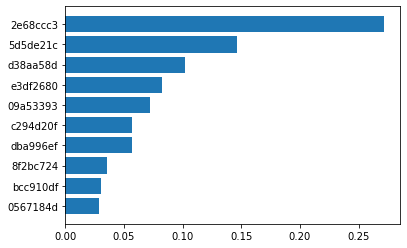

In [117]:
from matplotlib import pyplot as plt
plt.barh(top_10_important_events['Event'], top_10_important_events['Importance'])

### Variable Importance for XGBoost

In [122]:
importance_xgb_df = pd.DataFrame([events, importances_xgb]).T.set_axis(["Event", "Importance"], axis = 1)
top_10_important_events_xgb = importance_xgb_df.sort_values(by = ['Importance'], ascending = False)[0:10]
top_10_important_events_xgb = top_10_important_events_xgb.sort_values(by = ['Importance'])

<BarContainer object of 10 artists>

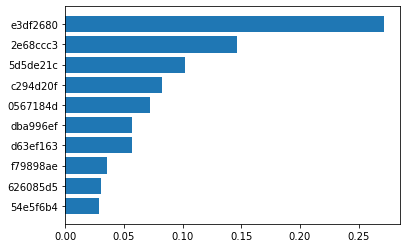

In [123]:
plt.barh(top_10_important_events_xgb['Event'], top_10_important_events['Importance'])